# Dataset 

In [10]:
import sys
sys.path.append('../../datasets/')
from prepare_sequences import prepare, germanBats
import matplotlib.pyplot as plt
import pickle
import numpy as np

classes = germanBats

In [23]:
num_bands = 257
patch_len = 44                               # = 250ms ~ 25ms
patch_skip = patch_len / 2                   # = 150ms ~ 15ms
seq_len = 60                                 # = 500ms with ~ 5 calls
seq_skip = 15

X_test, Y_test = prepare("../../datasets/prepared.h5", classes, patch_len, patch_skip, seq_len, seq_skip, only_test=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:38<00:00,  2.13s/it]


In [24]:
print("Total sequences:", len(X_test))
print(X_test.shape, Y_test.shape)

Total sequences: 4979
(4979, 60, 44, 257) (4979,)


In [20]:
'''n_X_test = []
n_Y_test = []

with open('../call_nocall_seq.indices', 'rb') as file:
    indices, labels = pickle.load(file)
    test_indices = np.asarray(indices[1])
    for i, seq_idx in enumerate(test_indices):
        n_X_test.append(X_test[i][seq_idx])'''

# Model

In [25]:
from torch.utils.data import TensorDataset, DataLoader
import torch

batch_size = 1

test_data = TensorDataset(torch.Tensor(X_test), torch.from_numpy(Y_test))
test_loader = DataLoader(test_data, batch_size=batch_size)

In [26]:
model = torch.jit.load("baseline.pt")
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, device_ids=[0, 1])
model.to(device)
print(device)

cuda:0


In [27]:
call_nocall_model = torch.jit.load('../call_nocall/call_nocall.pt')
call_nocall_model.to(device)

RecursiveScriptModule(
  original_name=ResNet
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
  (relu): RecursiveScriptModule(original_name=ReLU)
  (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
  (layer1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=Block
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
      (conv2): RecursiveScriptModule(original_name=Conv2d)
      (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
      (conv3): RecursiveScriptModule(original_name=Conv2d)
      (bn3): RecursiveScriptModule(original_name=BatchNorm2d)
      (relu): RecursiveScriptModule(original_name=ReLU)
      (identity_downsample): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Conv2d)
        (1): RecursiveScriptModule(original_na

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import tqdm

Y_pred = []
Y_true = []
corrects = 0

model.eval()

# iterate over test data
for inputs, labels in tqdm.tqdm(test_loader):
    inputs, labels = inputs[0].to(device).unsqueeze(1), labels[0].to(device)
    cnc_outputs = call_nocall_model(inputs)
    _, cnc_pred = torch.max(cnc_outputs, 1) # call indices
    
    n_inputs = inputs[cnc_pred.nonzero().squeeze()]
    if n_inputs.shape[0] > 1:
        output = model(n_inputs)
        # try different aggregation functions: mean/sum, max/mode
        pred = torch.max(output, 1)[1]
        pred = torch.mode(pred)[0]
        Y_pred.append(pred.cpu().data.numpy()) # Save Prediction
        Y_true.append(labels.cpu().data.numpy()) # Save Truth

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4979/4979 [02:07<00:00, 38.98it/s]


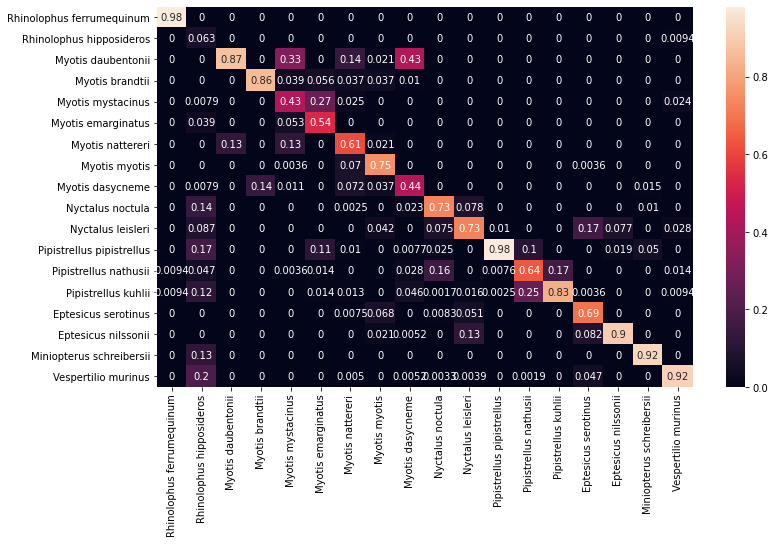

In [44]:
import numpy as np

# Build confusion matrix
cf_matrix = confusion_matrix(Y_true, Y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=0), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('seq_test_cf.png')

In [45]:
from sklearn.metrics import f1_score
corrects = np.equal(Y_pred, Y_true).sum()
print("Test accuracy:", corrects/len(Y_pred))
print("F1-score:", f1_score(Y_true, Y_pred, average=None).mean())

Test accuracy: 0.7229894394800975
F1-score: 0.6598738471618424


In [46]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

6148050
